In [14]:
# =============================================================================
# 1. Leitura e visão geral
# =============================================================================
import pandas as pd
import numpy as np

# 8152 exemplos, 38 atributos numéricos + id + classe “result”
df = pd.read_csv('jogosLoL2021.csv')  
df.drop(columns=['id'], inplace=True)      # descartar id
df.rename(columns={'result':'y'}, inplace=True)



In [15]:
# =============================================================================
# 2. Conjuntos de atributos por tarefa
# =============================================================================
all_cols = df.columns.tolist()
# colunas “at 15” e “at 10”:
cols15 = [c for c in all_cols if c.endswith('at15')]
cols10 = [c for c in all_cols if c.endswith('at10')]
# pré-jogo = todas menos at10/at15 e y
pre = [c for c in all_cols if c not in cols10+cols15+['y']]

feature_sets = {
    'I':  pre,              # apenas pré-jogo
    'II': cols10,           # apenas 10'
    'III': pre + cols10,    # pré + 10'
    'IV':  cols15,          # apenas 15'
    'V':   pre + cols10 + cols15,
}

# escolha a tarefa:
TASK = 'V'  
X = df[feature_sets[TASK]]
y = df['y']



In [16]:
# =============================================================================
# 3. Pipelines de pré-processamento
# =============================================================================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preproc = Pipeline([
    ('scaler', StandardScaler())
])



In [17]:
# =============================================================================
# 4. Definição dos classificadores e grades
# =============================================================================
from sklearn.tree       import DecisionTreeClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble   import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# scikit‐learn + random_state=13
clfs = {
    'DT':  DecisionTreeClassifier(random_state=13),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(random_state=13, max_iter=200),
    'RF':  RandomForestClassifier(random_state=13),
}
param_grids = {
    'DT':  {'criterion':['gini','entropy'], 'max_depth':[5,10,15,25]},
    'KNN': {'n_neighbors':[1,3,5,7,9]},
    'MLP': {'hidden_layer_sizes':[(100,),(10,)], 'alpha':[1e-4,5e-3], 'learning_rate':['constant','adaptive']},
    'RF':  {'n_estimators':[5,10,15,25], 'max_depth':[10,None]},
}
# HB vai depois



In [ ]:
# =============================================================================
# 5. Implementação de Heterogeneous Boosting (HB)
# =============================================================================
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class HeterogeneousBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=10, random_state=13):
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X, y):
        # converte X,y para ndarray se vierem como DataFrame/Series
        X_arr = X.values if hasattr(X, "values") else X
        y_arr = y.values if hasattr(y, "values") else y

        N = X_arr.shape[0]
        # encontra classe mais frequente para desempate
        vals, cnts = np.unique(y_arr, return_counts=True)
        self.class_counts_ = dict(zip(vals, cnts))
        self.most_freq_ = vals[np.argmax(cnts)]

        # pesos iniciais iguais
        w = np.ones(N) / N

        # base learners em ordem de desempate
        self.base_types_ = [
            MLPClassifier(random_state=self.random_state, max_iter=200),
            DecisionTreeClassifier(random_state=self.random_state),
            KNeighborsClassifier(),
            GaussianNB()
        ]

        self.ensemble_ = []
        rng = np.random.RandomState(self.random_state)

        for m in range(self.n_estimators):
            # seleção de exemplos por roleta
            idx = rng.choice(N, size=N, replace=True, p=w)
            Xs, ys = X_arr[idx], y_arr[idx]

            # seleciona melhor base no subsample
            best_acc, best_clf = -1, None
            for template in self.base_types_:
                clf = clone(template)
                clf.fit(Xs, ys)
                acc = (clf.predict(Xs) == ys).mean()
                if acc > best_acc:
                    best_acc, best_clf = acc, clf

            self.ensemble_.append(best_clf)

            # ajusta pesos: dobra peso dos erros
            y_pred_full = best_clf.predict(X_arr)
            errs = (y_pred_full != y_arr)
            w[errs] *= 2
            w /= w.sum()

        return self

    def predict(self, X):
        # mesma conversão
        X_arr = X.values if hasattr(X, "values") else X

        # coleta votos
        votes = np.vstack([clf.predict(X_arr) for clf in self.ensemble_])
        final = []
        for col in votes.T:
            vals, cnts = np.unique(col, return_counts=True)
            max_cnt = cnts.max()
            tied = vals[cnts == max_cnt]
            # se empate, usa classe mais frequente do treino
            if len(tied) > 1:
                # seleciona entre as empates a classe com maior contagem na classe original
                chosen = max(tied, key=lambda cls: self.class_counts_[cls])
                final.append(chosen)
            else:
                final.append(vals[np.argmax(cnts)])

        return np.array(final)
    
# grid HB
hb_grid = {'n_estimators':[5,10,15,25,50]}



In [ ]:
# =============================================================================
# 6. Validação aninhada + coleta de resultados
# =============================================================================
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score

outer_cv = RepeatedStratifiedKFold(n_splits=10, random_state=36854321, n_repeats=3)



results = {}
for name, clf in clfs.items():
    pipe = Pipeline([('pre',preproc), (name, clf)])
    grid = GridSearchCV(pipe, 
                        {f'{name}__'+k:v for k,v in param_grids[name].items()},
                        cv=4, scoring='accuracy', n_jobs=-1)
    scores = cross_val_score(grid, X, y, cv=outer_cv, scoring='accuracy', n_jobs=-1)
    results[name] = scores

# HB 
hb_scores = []
for n in hb_grid['n_estimators']:
    hb = Pipeline([('pre',preproc),('hb', HeterogeneousBoosting(n_estimators=n, random_state=36854321))])
    grid = GridSearchCV(hb, 
                        {'hb__n_estimators': [n]}, 
                        cv=4, scoring='accuracy', n_jobs=-1)
    hb_scores.append( cross_val_score(grid, X, y, cv=outer_cv, scoring='accuracy', n_jobs=-1) )
# escolher melhor n_estimators por métrica média
best_i = np.argmax([s.mean() for s in hb_scores])
results['HB'] = hb_scores[best_i]



  Método     Média       Std  IC 95% (inf)  IC 95% (sup)
0     DT  0.748694  0.016787      0.742425      0.754962
1    KNN  0.723916  0.018012      0.717190      0.730642
2    MLP  0.755400  0.018397      0.748530      0.762269
3     RF  0.753151  0.015739      0.747274      0.759028
4     HB  0.744604  0.012958      0.739766      0.749443


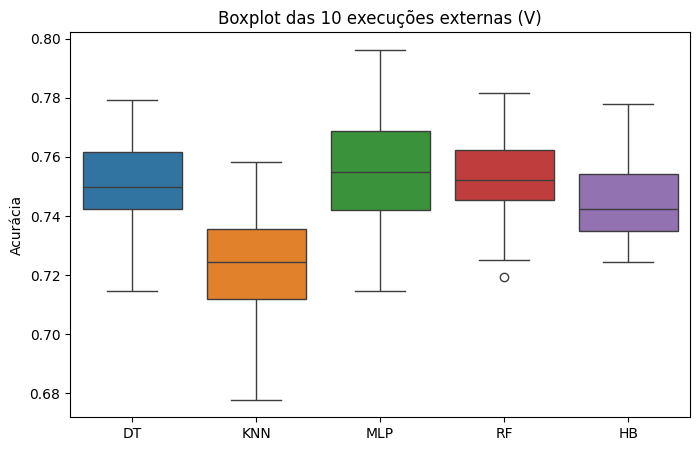

In [20]:
# =============================================================================
# 7. Estatísticas e Boxplots
# =============================================================================
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

summary = []
for m,s in results.items():
    mean = s.mean()
    std  = s.std(ddof=1)
    ci   = stats.t.interval(0.95, df=len(s)-1, loc=mean, scale=std/np.sqrt(len(s)))
    summary.append((m, mean, std, ci[0], ci[1]))
summary_df = pd.DataFrame(summary, columns=['Método','Média','Std','IC 95% (inf)','IC 95% (sup)'])
print(summary_df)

# boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=pd.DataFrame(results))
plt.ylabel('Acurácia')
plt.title(f'Boxplot das 10 execuções externas ({TASK})')
plt.show()



In [21]:
# =============================================================================
# 8. Testes pareados (t corrigido e Wilcoxon)
# =============================================================================
from itertools import combinations

# função t corrigido:
def t_corr(data1, data2, N, folds_ext):
    dif = np.array(data1) - np.array(data2)
    mean_diff = dif.mean()
    std_diff  = dif.std(ddof=1)
    # tamanho treino/teste externo
    n_test  = N // folds_ext
    n_train = N - n_test
    se = std_diff * np.sqrt(1/len(dif) + n_test/n_train)
    t_stat = mean_diff / se
    p_val  = 2*(1 - stats.t.cdf(abs(t_stat), df=len(dif)-1))
    return t_stat, p_val

methods = list(results.keys())
p_t = pd.DataFrame(np.ones((5,5)), index=methods, columns=methods)
p_w = p_t.copy()

for a,b in combinations(methods,2):
    tstat, pt = t_corr(results[a], results[b], X.shape[0], outer_cv.get_n_splits())
    wstat, pw = stats.wilcoxon(results[a], results[b])
    p_t.loc[a,b] = pt
    p_w.loc[b,a] = pw

# formatação de negrito:
def fmt_mat(df, level=0.05):
    def fmt(v):
        s = f"{v:.3f}"
        return f"*{s}*" if v<level else s
    return df.applymap(fmt)

paired_table = pd.DataFrame(index=methods, columns=methods)
for i in methods:
    for j in methods:
        if i==j:
            paired_table.loc[i,j] = '—'
        elif methods.index(i)<methods.index(j):  # triangular superior = t
            paired_table.loc[i,j] = fmt_mat(p_t).loc[i,j]
        else:                                     # inferior = Wilcoxon
            paired_table.loc[i,j] = fmt_mat(p_w).loc[i,j]

print("\nMatriz Pareada (sup=t, inf=Wilcoxon):")
print(paired_table)


Matriz Pareada (sup=t, inf=Wilcoxon):
          DT      KNN      MLP       RF       HB
DT         —  *0.000*  *0.023*    0.153    0.382
KNN  *0.000*        —  *0.000*  *0.000*  *0.000*
MLP  *0.003*  *0.000*        —    0.429  *0.017*
RF     0.092  *0.000*    0.271        —  *0.014*
HB     0.217  *0.000*  *0.002*  *0.002*        —


C:\Users\User\AppData\Local\Temp\ipykernel_26404\3395834065.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(fmt)
